1. We are using vgg16 network
2. This notebook was written on colab
3. content image - https://3.img-dpreview.com/files/p/TS1200x900~sample_galleries/1330372094/1693761761.jpg
4. style image - https://skyryedesign.com/wp-content/uploads/2016/06/1000charuk-famous-artist-watercolor-artists-new-artists-painting-artists-art-painting-painter-artist.jpg
5. apart from content and style loss we define a total variation loss which reduces the noise of output image.

In [3]:
!pip install -U scipy==1.2.0

Requirement already up-to-date: scipy==1.2.0 in /usr/local/lib/python3.6/dist-packages (1.2.0)


In [0]:
from __future__ import print_function

import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import matplotlib.pyplot as plt
from io import BytesIO
from google.colab import files


###setting height and width of the image


In [0]:
height = 512
width = 512

### Load the content image



Saving content_image.jpg to content_image (2).jpg


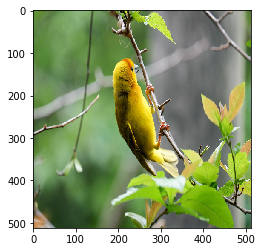

In [35]:
#via colab
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['content_image.jpg']))

#via local notebook
# content_image_path = 'content.jpg'
# content_image = Image.open(content_image_path)

content_image = im.resize((width, height))
plt.imshow(content_image)
plt.show()


### Load the style image


Saving style_image.jpg to style_image (3).jpg


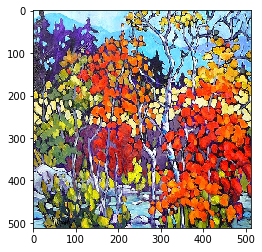

In [36]:
#via colab
uploaded = files.upload()
im = Image.open(BytesIO(uploaded['style_image.jpg']))

#via local notebook
# style_image_path  = 'style.jpg'
# style_image  = Image.open(style_image_path )

style_image  = im.resize((width, height))
plt.imshow(style_image)
plt.show()


###Convert images to 4_D array


In [37]:
content_array = np.asarray(content_image, dtype= 'float32')
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype= 'float32')
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

(1, 512, 512, 3)
(1, 512, 512, 3)


###1) Subtract the mean RGB value from each channel in the input
**why** ? - https://stackoverflow.com/questions/48201735/why-does-vgg19-subtract-the-mean-rgb-values-of-inputs
###2) Flip the multidimensional array from RGB to BGR
**why** ? - vgg16 is trained on caffe and it used opencv which loads image in brg by default. ->https://github.com/jcjohnson/neural-style/issues/207

In [0]:

content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

##Backend variables in Keras Backend

In [49]:
content_image = backend.variable(content_array)
style_image = backend.variable(style_array)
combination_image = backend.placeholder((1, height, width, 3))
print(content_image)
print(style_image)
print(combination_image)

<tf.Variable 'Variable_14:0' shape=(1, 512, 512, 3) dtype=float32_ref>
<tf.Variable 'Variable_15:0' shape=(1, 512, 512, 3) dtype=float32_ref>
Tensor("Placeholder_3:0", shape=(1, 512, 512, 3), dtype=float32)


###Concatenate all image data into a single tensor
we'll feed this whole tensor into the vgg16 and get feature representation from various middle layers instead of the final output.

In [51]:
input_tensor = backend.concatenate([content_image, style_image, combination_image], axis = 0)
print(input_tensor)


Tensor("concat_2:0", shape=(3, 512, 512, 3), dtype=float32)


###model object without the top layers/fully connected layers
Model initlization

In [52]:
model = VGG16(input_tensor=input_tensor, weights='imagenet', include_top = False)





58892288/58889256 [==============================] - 1s 0us/step








In [55]:
#dict containing name of layers and respective outputs for input tensor define in upper cells.
layers = dict([(layer.name, layer.output) for layer in model.layers])
print(layers)

{'input_1': <tf.Tensor 'concat_2:0' shape=(3, 512, 512, 3) dtype=float32>, 'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 512, 512, 64) dtype=float32>, 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 256, 256, 64) dtype=float32>, 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 256, 256, 128) dtype=float32>, 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 128, 128, 128) dtype=float32>, 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 128, 128, 256) dtype=float32>, 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 64, 64, 256) dtype=float32>, 'block4_conv1': <tf.Tensor 

In [0]:
#Defining alpha and beta hyperparameters
content_weight = 0.025
style_weight = 5.0
total_variation_weight = 1.0

In [0]:
#Instantiates a variable and returns it. https://www.tensorflow.org/api_docs/python/tf/keras/backend/variable
loss = backend.variable(0.)

#Loss Functions

##Content Loss
![Imgur](https://i.imgur.com/ahYHnUs.jpg)

In [0]:
def content_loss(content, combination):
    '''
    half of summation of square of difference between feature representation of 
    generated image and content image.
    '''
    return (1/2)*backend.sum(backend.square(combination - content))

In [0]:
layer_features = layers['block2_conv2']
content_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]

In [0]:
loss = loss + content_weight * content_loss(content_image_features, combination_features)


##The style loss
![Imgur](https://i.imgur.com/Nax3jto.jpg)

In [0]:

def gram_matrix(x):
    '''
    batch_flatten - Turn a nD tensor into a 2D tensor with same 0th dimension.
    rearrange the dimentions from 0,1,2 to 2,0,1 and 2D flatten it
    that is a 5*4*3 image to 3*4*5 to 3*20
    then dot product of 2D vector with it's transpose.
    '''
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

def style_loss(style, combination):
    '''
    summation of square of difference between gram marices of generated image 
    and style image divided by some constant.
    '''
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = height * width
    return backend.sum(backend.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
#VGG16 layers used
feature_layers = ['block1_conv2', 'block2_conv2', 
                  'block3_conv3', 'block4_conv3', 
                  'block5_conv3']

In [0]:
#style loss is computed for all layers mentioned above to compute similarity between all those layer's channels.
for layer_name in feature_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, : ,: ,:]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_features, combination_features)
    loss += (style_weight / len(feature_layers)) * sl

In [0]:
# def total_variation_loss(x):
#     '''
#     This loss is defined to lessen the noise of generated image
#     '''
#     a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
#     b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
#     return backend.sum(backend.pow(a + b, 1.25))


In [0]:
# loss += total_variation_weight * total_variation_loss(combination_image)



In [0]:
#Returns the gradients of loss w.r.t. variables.

grads = backend.gradients(loss, combination_image)


In [0]:
outputs = [loss]
outputs += grads
f_outputs = backend.function([combination_image], outputs)